<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Gillespie_Non_markovian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo Gillespie no-markoviano en redes.

In [8]:
not True

False

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton
import networkx as nx
def Gillespie_Direct_Method_Mon_Markovian_Networkk(N,X_I_indexes,params=[],densities=[],survivals=[],G_network_initial=nx.Graph(),T=np.inf):
### Algoritmo
    if(len(params)>0):
        a_I,a_R,lammbda_I,lammbda_R=params
        def psi_survival_infection(x):
            return np.exp(-(lammbda_I*x)**(a_I))
        def psi_survival_recovery(x):
            return np.exp(-(lammbda_R*x)**(a_R))
        def psi_infection(x):
            return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
        def psi_recovery(x):
            return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))
        general=False
    else:
        psi_infection = lambda x:densities[0](x)
        psi_recovery = lambda x:densities[1](x)
        psi_survival_infection = lambda x:survivals[0](x)
        psi_survival_recovery = lambda x:survivals[1](x)
        general=True
    pos=nx.spring_layout(G_network_initial,seed=2,k=3)
#Paso 1.
    t=0
    aristas_en_riesgo={'arista':[],'tiempo':[]}
    vertices_infecciosos={'vertice':[],'tiempo':[]}
    #Llenar estos arreglos.
    #N es el número de individuos.
    for j in X_I_indexes:
        vertices_infecciosos['vertice'].append(j)
        vertices_infecciosos['tiempo'].append(0)
        for i in range(N):
            if G_network_initial.has_edge(i,j):
                aristas_en_riesgo['arista'].append((min(i,j),max(i,j)))
                aristas_en_riesgo['tiempo'].append(0)
    flag=True
#---------------------------
    count=0
    Tuto=False
    hist=[]
    tau=0.5
    X_I=len(X_I_indexes)
    while(X_I>0):
        count+=1
        #Paso 2.
        #Definir Phi(tau|{t_j}):
        #---------------------------
        #Paso 3.
        #Generar el tiempo de siguiente reaccion:
        u=np.random.uniform()
        if (not general):  
            def f_to_solve(x):
                S_1=np.sum([(x+r)**(a_I) for r in aristas_en_riesgo['tiempo']])
                S_2=np.sum([(x+r)**(a_R) for r in vertices_infecciosos['tiempo']])
                S_3=np.sum([r**a_I for r in aristas_en_riesgo['tiempo']])
                S_4=np.sum([r**a_R for r in vertices_infecciosos['tiempo']])
                return ((lammbda_I**(a_I))*(S_1-S_3)+(lammbda_R**(a_R))*(S_2-S_4)+np.log(u))
            def f_to_solve_prime(x):
                S_1=a_I*np.sum([(x+r)**(a_I-1) for r in aristas_en_riesgo['tiempo']])
                S_2=a_R*np.sum([(x+r)**(a_R-1) for r in vertices_infecciosos['tiempo']])
                return (a_I*(lammbda_I**(a_I))*S_1+a_R*(lammbda_R**(a_R))*S_2)
            try:
                tau=newton(func=f_to_solve,x0=tau/2,fprime=f_to_solve_prime)
            except:
                print("Error in fsolve, pero se obtiene",tau)
                print(aristas_en_riesgo['tiempo'])
                print(vertices_infecciosos['tiempo'])
                break
        else:
            def f_to_solve_general(x):
                S_1=np.sum([np.log(psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
                S_2=np.sum([np.log(psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
                S_3=np.sum([np.log(psi_survival_infection(r)) for r in aristas_en_riesgo['tiempo']])
                S_4=np.sum([np.log(psi_survival_recovery(r)) for r in vertices_infecciosos['tiempo']])
                return (S_1+S_2-S_3-S_4-np.log(u))
            def f_to_solve_general_prime(x):
                S_1=np.sum([(psi_infection(x+r)/psi_survival_infection(x+r)) for r in aristas_en_riesgo['tiempo']])
                S_2=np.sum([(psi_recovery(x+r)/psi_survival_recovery(x+r)) for r in vertices_infecciosos['tiempo']])
                return (-S_1-S_2)
            try:
                tau=newton(func=f_to_solve_general,x0=tau/2,fprime=f_to_solve_general_prime)
            except:
                print("Error in fsolve, pero se obtiene",tau)
                print(aristas_en_riesgo['tiempo'])
                print(vertices_infecciosos['tiempo'])
                break
        t+=tau
        #-------------------------
        #Paso 4. 
        #Definir las cantidades $phi(tau,i|t_i) 
        #Paso 5.
        #Calcular las probabilidades $Pi_j$
        if not general:
            pi_s_teoricas=[]
            sum=0
            for j in range(len(aristas_en_riesgo['tiempo'])):
                pi_s_teoricas.append(lammbda_I*a_I*(lammbda_I*(tau+aristas_en_riesgo['tiempo'][j]))**(a_I-1))
                sum+=pi_s_teoricas[-1]
            for j in range(len(vertices_infecciosos['tiempo'])):
                pi_s_teoricas.append(lammbda_R*a_R*(lammbda_R*(tau+vertices_infecciosos['tiempo'][j]))**(a_R-1))
                sum+=pi_s_teoricas[-1]
            pi_s=pi_s_teoricas/sum
        else:
            pi_s=[]
            sum=0
            for i in range(len(aristas_en_riesgo['tiempo'])):
                pi_s.append(psi_infection(aristas_en_riesgo['tiempo'][i]+tau)/psi_survival_infection(aristas_en_riesgo['tiempo'][i]+tau))
                sum+=pi_s[-1]
            for i in range(len(vertices_infecciosos['tiempo'])):
                pi_s.append(psi_recovery(vertices_infecciosos['tiempo'][i]+tau)/psi_survival_recovery(vertices_infecciosos['tiempo'][i]+tau))
                sum+=pi_s[-1]
            pi_s=pi_s/sum
        #-------------------------
        #Paso 6.
        #Decidir el canal de reacción.
        u_2=np.random.uniform()
        D=pi_s[0]
        k=0
        while(u_2>D):
            k+=1
            D+=pi_s[k]
        #-------------------------
        #Paso 7 y 8.
        #Actualizacion de tiempos DESDE la ultima reaccion (en todos los canales).
        aristas_en_riesgo['tiempo']=[tau+x for x in aristas_en_riesgo['tiempo']]################################3
        vertices_infecciosos['tiempo']=[tau+x for x in vertices_infecciosos['tiempo']]
        #-------------------------
        #Identificar la reaccion
        if(k<len(aristas_en_riesgo['tiempo'])):#Infeccion
            reaccion='infeccion'
            X_I+=1
            #arista
            arista_elegida=aristas_en_riesgo['arista'][k]
            involucrado_1,involucrado_2=arista_elegida[0],arista_elegida[1]
            #Identificar al nuevo infectado-------------
            if(G_network_initial.nodes[involucrado_1]['Estado:']=='Susceptible'):
                #involucrado_1 es el nuevo infeccioso
                nuevo_infectado=involucrado_1
            else:
                if(G_network_initial.nodes[involucrado_1]['Estado:']=='Infeccioso'):
                    nuevo_infectado=involucrado_2
                else:
                    print("Epale")
            G_network_initial.nodes[nuevo_infectado]['Estado:']='Infeccioso'#Actualizacion en el grafo.
            #-------------------------
            #Agregarlo a la lista vertices_infecciosos con tiempo 0----
            vertices_infecciosos['vertice'].append(nuevo_infectado)
            vertices_infecciosos['tiempo'].append(0)
            #-------------------------
            #Agrega a la lista aristas_en_riesgo a aquellas nuevas aristas que podrían provocar una infección, con tiempo 0.
            for nei in G_network_initial.neighbors(nuevo_infectado):
                if(G_network_initial.nodes[nei]['Estado:']=='Susceptible'):
                    aristas_en_riesgo['arista'].append((min(nei,nuevo_infectado),max(nei,nuevo_infectado)))
                    aristas_en_riesgo['tiempo'].append(0)
                else:
                    if(G_network_initial.nodes[nei]['Estado:']=='Infeccioso'):
                        index=aristas_en_riesgo['arista'].index((min(nuevo_infectado,nei),max(nuevo_infectado,nei)))
                        aristas_en_riesgo['arista'].pop(index)
                        aristas_en_riesgo['tiempo'].pop(index)
            #-------------------------
            #Elimina de la lista aristas_en_riesgo a la arista que provocó la nueva infeccion
            #-------------------------
            nuevo_involucrado=nuevo_infectado
            #-------------------------
            #Elimina de la lista aristas_en_riesgo a las aristas que ya no son viables. I.e. involucra a dos infecciosos.
            #-------------------------
        else:#Recuperacion.
            X_I-=1
            reaccion='recuperacion'
            indice_respecto_vertices=k-len(aristas_en_riesgo['tiempo'])
            nuevo_recuperado=vertices_infecciosos['vertice'][indice_respecto_vertices]
            #Actualiza el estado a Recuperado.
            G_network_initial.nodes[nuevo_recuperado]['Estado:']='Recuperado'#Actualizacion en el grafo.
            #-----------------------------
            #Elimina de la lista vertices_infecciosos al nuevo recuperado.
            vertices_infecciosos['vertice'].pop(indice_respecto_vertices)
            vertices_infecciosos['tiempo'].pop(indice_respecto_vertices)
            #-----------------------------
            #Elimina de la lista aristas_en_riesgo a aquellas aristas que involucran al nuevo recuperado.
            aristas_en_riesgo_copia=aristas_en_riesgo['arista'].copy()
            count=-1
            for l in range(len(aristas_en_riesgo_copia)):
                edge=aristas_en_riesgo_copia[l]
                if(edge[0]==nuevo_recuperado or edge[1]==nuevo_recuperado):
                    count+=1
                    aristas_en_riesgo['arista'].pop(l-count)
                    aristas_en_riesgo['tiempo'].pop(l-count)
            #-----------------------------
            nuevo_involucrado=nuevo_recuperado
        if(Tuto):
            print("-"*30)
            #print("En la siguiente iteración ocurre: \\n \\t *Se genera el tiempo "+str(tau)+"\\n\\t *Se selecciona el canal " +str(k)+ ", que significa "+reaccion+" del individuo " +str(nuevo_involucrado))
            print("-"*30)
            print("\n La grafica se ve asi: ")
            nx.draw(G_network_initial, pos,with_labels=True,node_color=['r' if G_network_initial.nodes[i]['Estado:']=='Infeccioso' else 'g' if G_network_initial.nodes[i]['Estado:']=='Susceptible' else 'gray' for i in range(N)])
            plt.show()
        hist.append([t,X_I])
        if(X_I==0):
            flag=False
    H=pd.DataFrame(hist,columns=['time','I(t)'])
    return H

--- 8.632590293884277 Segundos para crear la gráfica ---
Empieza
--- 96.86018702983856 Segundos en promedio para ejecutar 1 iteracion del general ---
--- 20.986786985397337 Segundos en promedio para ejecutar 1 iteracion del weibull ---


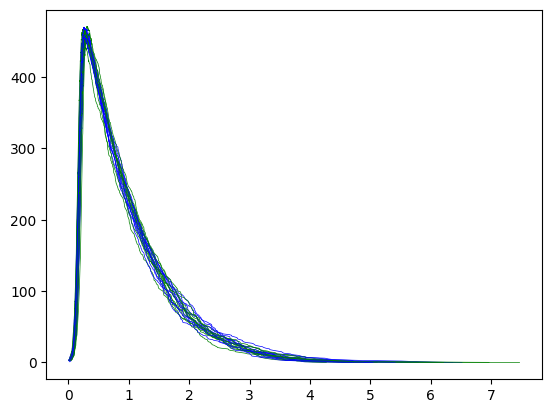

In [24]:
import time
start_time = time.time()
N=100*5
n=int(N*0.1)
ksum=1
np.random.seed(2)
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(n,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
pos=nx.spring_layout(G,seed=2,k=3)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=[0,2]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")
a_I=1.2
a_R=1.2
lammbda_I=1.25
lammbda_R=1.0
def psi_survival_infection(x):
    return np.exp(-(lammbda_I*x)**(a_I))
def psi_survival_recovery(x):
    return np.exp(-(lammbda_R*x)**(a_R))
def psi_infection(x):
    return (lammbda_I*a_I)*(lammbda_I*x)**(a_I-1)*np.exp(-(lammbda_I*x)**(a_I))
def psi_recovery(x):
    return (lammbda_R*a_R)*(lammbda_R*x)**(a_R-1)*np.exp(-(lammbda_R*x)**(a_R))
beta=1.25
gamma=1
times_general=[]
times_weibull=[]
for k in range(10):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    H=Gillespie_Direct_Method_Mon_Markovian_Networkk(params=[1.2,1.2,1.25,1.0],N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    times_weibull.append((time.time() - iter_time))
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()  
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'green',linewidth=0.5)
    H=Gillespie_Direct_Method_Mon_Markovian_Networkk(densities=[psi_infection,psi_recovery],survivals=[psi_survival_infection,psi_survival_recovery],N=N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=np.inf)
    times_general.append((time.time() - iter_time))
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'blue',linewidth=0.5)
print("--- %s Segundos en promedio para ejecutar 1 iteracion del general ---" %np.mean(times_general))    
print("--- %s Segundos en promedio para ejecutar 1 iteracion del weibull ---" % np.mean(times_weibull))  


--- 73.28640460968018 Segundos para crear la gráfica ---
Empieza
--- 144.42732524871826 Segundos para ejecutar 1 iteracion ---
--- 143.8724868297577 Segundos para ejecutar 1 iteracion ---
--- 140.44567131996155 Segundos para ejecutar 1 iteracion ---
--- 144.3080563545227 Segundos para ejecutar 1 iteracion ---
--- 141.6064612865448 Segundos para ejecutar 1 iteracion ---


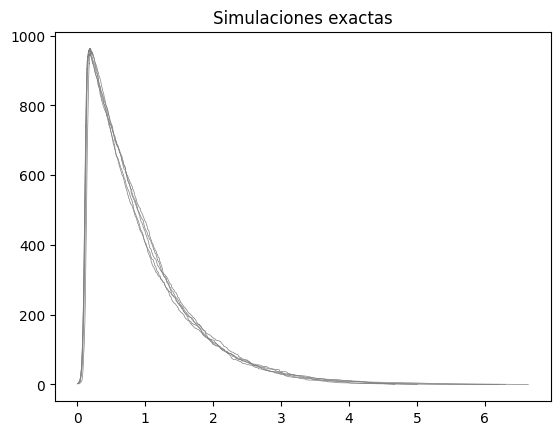

In [ ]:
import time
start_time = time.time()
N=10**3
n=int(N*0.1)
ksum=1
np.random.seed(2)
while(ksum%2!=0):#Que defina una grafica.
        k_dist=np.random.poisson(n,size=N)
        ksum=sum(k_dist)
G=nx.random_degree_sequence_graph(k_dist)
pos=nx.spring_layout(G,seed=2,k=3)
print("--- %s Segundos para crear la gráfica ---" % (time.time() - start_time))
graph_time = time.time()
np.random.seed(0)
X_I_indexes=[0]
for k in range(N):
    if k in X_I_indexes:
        G.nodes[k]['Estado:']='Infeccioso'
    else:
        G.nodes[k]['Estado:']='Susceptible'
print("Empieza")

S_0=N-1
I_0=N-S_0
beta=1.25
gamma=1
for k in range(5):
    H=[]
    G_copy=G.copy()
    X_I_indexes_copy=X_I_indexes.copy()
    iter_time = time.time()
    H=Gillespie_Direct_Method_Mon_Markovian_Networkk(a_I=1.2,a_R=1.2,lammbda_I=1.25,lammbda_R=1,N=N,X_I_indexes=[0],G_network_initial=G_copy,T=np.inf)
    print("--- %s Segundos para ejecutar 1 iteracion ---" % (time.time() - iter_time))    
    H=pd.DataFrame(H,columns=['time','S(t)','I(t)'])
    plt.plot(H['time'],H['I(t)'], 'gray',linewidth=0.5)
plt.title('Simulaciones exactas')
plt.show()